In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Parámetros del Mallado

In [2]:
### RECORREMOS UNA PROFUNDIDAD

dz = 0.01e-6 ## Paso en Profundidad  nm
start_z = 0e-6
stop_z = 5e-6

dx = 0.01e-6  ## Paso en Superficie um
start_x = 0e-6
stop_x = 5e-6

### EN UN TIEMPO 
dt = 50e-15  ## Time Step fs
start_t = 0
stop_t = 20e-12 ## Finalizamos a ps


x = np.linspace(start_x,stop_x,int(round((stop_x-start_x)/dx)))
z = np.linspace(start_z,stop_z,int(round((stop_z-start_z)/dz)))
t = np.linspace(start_t,stop_t,int(round((stop_t-start_t)/dt)))

X,Z= np.meshgrid(x,z)

### Parámetros Generales Red y Láser

In [3]:
# ------------- Red Electrones -----------------
Ce_aux = 134.5*10000 # J / (m^3 K^2)
ke = 235  # J /(m K s)
G = 5.69e17 # J /(m K^3 s)

#  ----------------------------------------------

# ------------- Red Lattice -----------------
Ci = 2.42e6  # J / (m^3 K)
ki = ke/99 # J (m K^3 s) 
#  -------------------------------------------


# ------------- Parámetros Láser -----------------
R = 0.88 # Reflectancia A.U.
delta = 20e-9 # Optical Penetration (nm)
ball_len = 100e-9 # Ballistic Length (nm)
 
tp = 100e-15 # FWHM fs
w0 = 5e-6 # Waist um
wavelength = 1.032e-6 # Wavelength (um)
#  ------------------------------------------------------

# ------------- Parámetros Varios -----------------
ys = 3e-6 ## Perfil de Apertura del Láser (um)
T0 = 300 # K Temperatura Ambiente (K)
x0 = 0 # Posición central del Spot en x
n = 1 ## Refractive Index
Zr = n*np.pi*w0**2/wavelength
w = w0*(1+Z**2/Zr**2)**1/2


Tc = 5370 # Temperatura Crítica (K)
f = 2e4 # J/m^2

In [4]:
S = (1-R)/(delta + ball_len) * f * w0**2/w**2 * np.exp(
    -(Z)/(delta+ball_len) - (2*(X-x0)**2/w**2))

T = 1/tp * np.sqrt(4 * np.log(2)/np.pi) * np.exp(
    -4*np.log(2) * ((t[0] - 2*tp)/tp)**2) 

Q = S*T

### Initial Conditions

In [5]:
Te = np.ones_like(X)*T0
Tl = np.ones_like(X)*T0

Teaux = np.ones_like(Te)*T0
Tlaux = np.ones_like(Tl)*T0

Tenew = np.ones_like(Te)*T0
Tlnew = np.ones_like(Tl)*T0


alpha_x = dt/dx/dx
alpha_z = dt/dz/dz

In [6]:
Ae = np.zeros((Te.shape[0],Te.shape[1]))
Ae_aux = np.zeros((Te.shape[0],Te.shape[1]))
Be = np.zeros((Te.shape[0],Te.shape[1]))
Be_aux = np.zeros((Te.shape[0],Te.shape[1]))

Al = np.zeros((Te.shape[0],Te.shape[1]))
Al_aux = np.zeros((Te.shape[0],Te.shape[1]))
Bl = np.zeros((Te.shape[0],Te.shape[1]))
Bl_aux = np.zeros((Te.shape[0],Te.shape[1]))

for i in range(1,(int(stop_z/dz)-1)):
    for j in range(1,int((stop_x/dx)-1)):
        # print("BUCLE?")
        if i == j:
            # print("HOLA")
            ### COMPONENTES ELECTRONICOS
            Ae[i-1][j] = -0.5*ke/Ce_aux*alpha_z
            Ae[i][j] = 1+ke/Ce_aux*alpha_z
            Ae[i+1][j] = -0.5*ke/Ce_aux*alpha_z
            

            Be[i][j-1] = 0.5 * ke/Ce_aux* alpha_x
            Be[i][j] = 1 - ke/Ce_aux *alpha_x - 0.5* dt/Ce_aux * G 
            Be[i][j+1] = 0.5 * ke/Ce_aux* alpha_x

            Ae_aux[i][j-1] = -0.5*ke/Ce_aux*alpha_x
            Ae_aux[i][j] = 1+ke/Ce_aux*alpha_x
            Ae_aux[i][j+1] = -0.5*ke/Ce_aux*alpha_x
            
            Be_aux[i-1][j] = 0.5 * ke/Ce_aux* alpha_z
            Be_aux[i][j] = 1 - ke/Ce_aux *alpha_z - 0.5* dt/Ce_aux * G 
            Be_aux[i+1][j] = 0.5 * ke/Ce_aux* alpha_z
            
            ### COMPONENTES LATTICE
            
            Al[i-1][j] = -0.5* ki/Ci* alpha_z 
            Al[i][j] = (1 + ki/Ci*alpha_z)
            Al[i+1][j] = -0.5*ki/Ci * alpha_z
            

            Bl[i][j-1] = 0.5*alpha_x*ki/Ci 
            Bl[i][j] = (1-ki/Ci*alpha_x - 0.5*dt/Ci *G)
            Bl[i][j+1] = 0.5*alpha_x*ki/Ci 

            Al_aux[i][j-1] = -0.5* alpha_x*ki/Ci
            Al_aux[i][j] =  1 + alpha_x*ki/Ci
            Al_aux[i][j+1] = -0.5* alpha_x*ki/Ci
            
            Bl_aux[i-1][j] = 0.5*alpha_z*ki/Ci
            Bl_aux[i][j] = (1-ki/Ci*alpha_z - 0.5*dt/Ci*G)
            Bl_aux[i+1][j] = 0.5*alpha_z*ki/Ci

            
Ae[0][0],Be[0][0],Ae_aux[0][0],Be_aux[0][0] = 1,1,1,1
Ae[-1][-1],Be[-1][-1],Ae_aux[-1][-1],Be_aux[-1][-1] = 1,1,1,1


Al[0][0],Bl[0][0],Al_aux[0][0],Bl_aux[0][0] = 1,1,1,1
Al[-1][-1],Bl[-1][-1],Al_aux[-1][-1],Bl_aux[-1][-1] = 1,1,1,1

Ae_inv = np.linalg.inv(Ae)
Ae_aux_inv = np.linalg.inv(Ae_aux)

Al_inv = np.linalg.inv(Al)
Al_aux_inv = np.linalg.inv(Al_aux)

In [9]:
D = 0.5* Q * dt/Ce_aux + 0.5 * G *Tl * dt/Ce_aux
E =  0.5 * G *Te * dt/Ce_aux

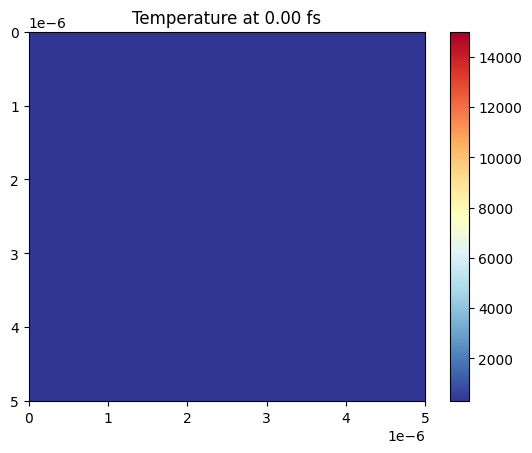

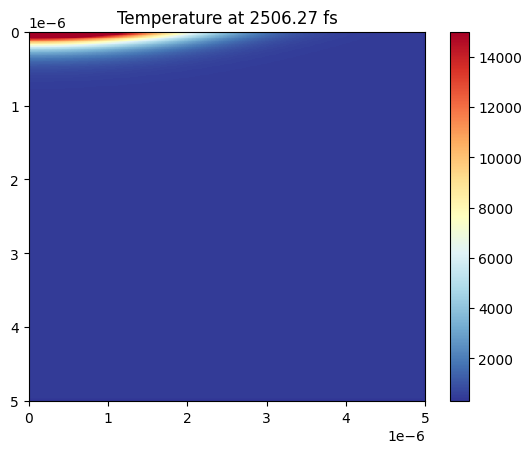

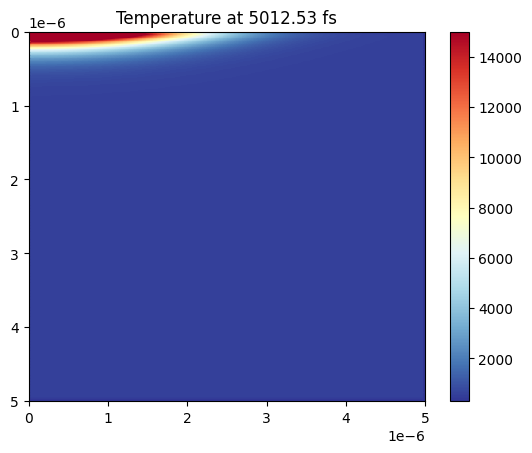

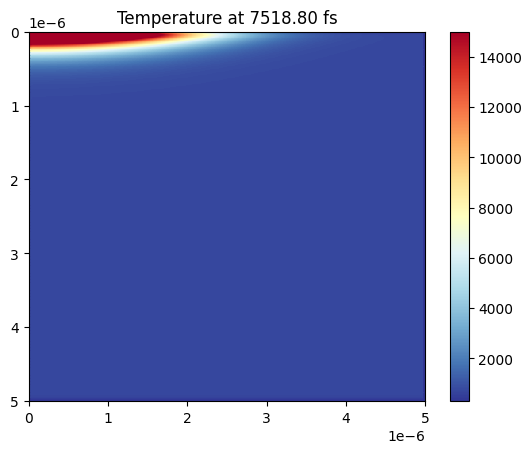

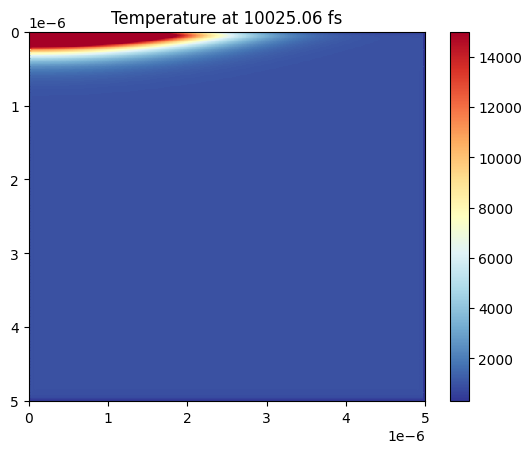

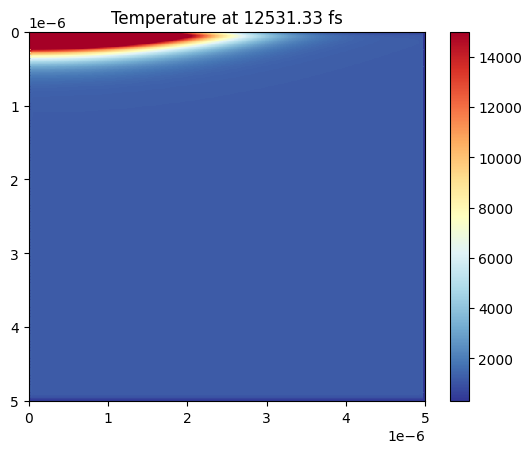

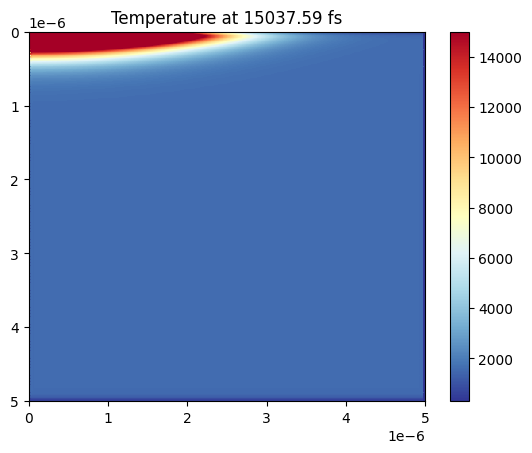

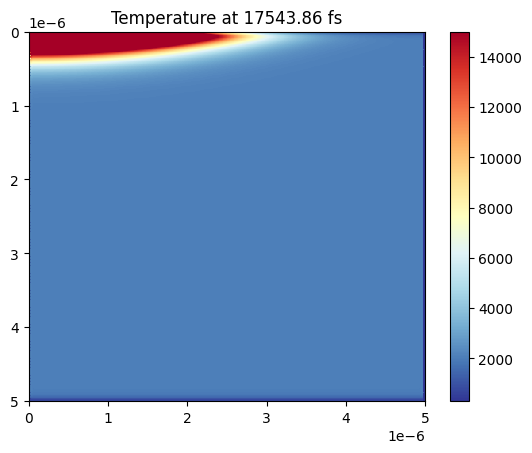

In [19]:
for k in range(len(t)-1):
    Teaux = np.matmul(np.matmul(Ae_aux_inv,Be_aux),Te) + np.matmul(Ae_aux_inv,D)   
    
    Tenew = np.matmul(np.matmul(np.transpose(Ae),np.transpose(Be)),np.transpose(Teaux)) + np.matmul(np.transpose(Ae),np.transpose(D))
    Tenew = np.transpose(Tenew)
    

    Tlaux = np.matmul(np.matmul(Al_aux_inv,Bl_aux),Tl) + np.matmul(Al_aux_inv,E)
    Tlnew = np.matmul(np.matmul(np.transpose(Al),np.transpose(Bl)),np.transpose(Tlaux)) + np.matmul(np.transpose(Al),np.transpose(E))
    Tlnew = np.transpose(Tlnew)
    
    
    Te = Tenew
    Tl = Tlnew
    
    Te[0,:], Te[-1,:], Te[:,0], Te[:,-1] = Te[1,:], Te[-2,:], Te[:,1], Te[:,-2]
    Tl[0,:], Tl[-1,:], Tl[:,0], Tl[:,-1] = Tl[1,:], Tl[-2,:], Tl[:,1], Tl[:,-2]
    
    T = 1/tp * np.sqrt(4 * np.log(2)/np.pi) * np.exp(
    -4*np.log(2) * ((t[k] - 2*tp)/tp)**2) 

    Q = S*T
    
    D = 0.5 * Q * dt/Ce_aux + 0.5 * G *Tl * dt/Ce_aux
    E = 0.5 * G * Te * dt/Ce_aux
    
    
    
    if k % 50 == 0:
        plt.pcolor(x,z,Tlnew,cmap='RdYlBu_r',vmin=300,vmax = 15000)
        plt.title(f"Temperature at {t[k]*1e15:.2f} fs")
        plt.colorbar(cmap='RdYlBu_r')
        plt.gca().invert_yaxis()
        plt.show()
    
    

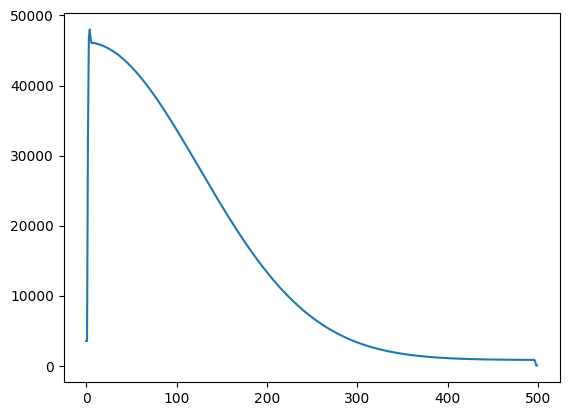

In [20]:
plt.plot(Tlnew[:,-1])